In [1]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.special import softmax
from pathlib import Path
from pytorch_lightning import seed_everything

from pruneshift.network_markers import at_entry_points
from pruneshift.losses import ActivationCollector

from matplotlib.pyplot import cm

import numpy as np
import submitit
import torch
import torch.nn.functional as F

from random import sample
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pruneshift.datamodules import ShiftDataModule
from pruneshift.networks import create_network

from utils import collect

model_path = Path("/work/dlclarge2/hoffmaja-pruneshift/models/")
dataset_path = Path("/work/dlclarge2/hoffmaja-pruneshift/datasets/")
activation_path = Path("/work/dlclarge2/hoffmaja-pruneshift/activations/")
img100_path = dataset_path / "ILSVRC2012-100"
img100_train_path = img100_path / "train"
img_path = "/data/datasets/ILSVRC2012/train"
deepaugment_path = "/data/datasets/DeepAugment"


teachers = 

INTRESTING_NETS = {
    "augmix_resnet50": "/work/dlclarge2/hoffmaja-pruneshift/models/imagenetr_models/augmix.pth.tar",
    "deep_resnet50": "/work/dlclarge2/hoffmaja-pruneshift/models/imagenetr_models/deepaugment.pth.tar",
    "amda_resnet50": "/work/dlclarge2/hoffmaja-pruneshift/models/imagenetr_models/deepaugment_and_augmix.pth.tar",
    "swsl_resnet50": "/work/dlclarge2/hoffmaja-pruneshift/models/torch_home/hub/checkpoints/semi_weakly_supervised_resnet50-16a12f1b.pth",
    "std_resnet50": "/work/dlclarge2/hoffmaja-pruneshift/models/torch_home/hub/checkpoints/resnet50-19c8e357.pth"}

In [2]:
# Find Students
df = collect("/work/dlclarge2/hoffmaja-pruneshift/experiments/img100/workshop/distillation/")

In [3]:
df_students = df.query("Scaling == 1 & Loss != 'ContrastiveDistill'")
df_students = df_students.append(collect("/work/dlclarge2/hoffmaja-pruneshift/experiments/img100/workshop/distillation/crd_settings/"))[["Loss", "Path", "Network", "Teacher"]]
df_students = df_students.query("Network == 'resnet18'")
df_students["Path"] += "/checkpoint/last.ckpt"

In [4]:
df_teachers = pd.DataFrame(INTRESTING_NETS.items())
df_teachers.columns = ["Teacher", "Path"]
df_teachers["Network"] = "resnet50"
df_teachers["Loss"] = "Teacher"

In [5]:
df_comb = pd.concat([df_teachers, df_students])

In [6]:
df_comb

,Teacher,Path,Network,Loss
0,augmix_resnet50,/work/dlclarge2/hoffmaja-pruneshift/models/ima...,resnet50,Teacher
1,deep_resnet50,/work/dlclarge2/hoffmaja-pruneshift/models/ima...,resnet50,Teacher
2,amda_resnet50,/work/dlclarge2/hoffmaja-pruneshift/models/ima...,resnet50,Teacher
3,swsl_resnet50,/work/dlclarge2/hoffmaja-pruneshift/models/tor...,resnet50,Teacher
4,std_resnet50,/work/dlclarge2/hoffmaja-pruneshift/models/tor...,resnet50,Teacher
270,std_resnet50,/work/dlclarge2/hoffmaja-pruneshift/experiment...,resnet18,AttentionDistill
270,swsl_resnet50,/work/dlclarge2/hoffmaja-pruneshift/experiment...,resnet18,AttentionDistill
270,swsl_resnet50,/work/dlclarge2/hoffmaja-pruneshift/experiment...,resnet18,KnowledgeDistill
270,amda_resnet50,/work/dlclarge2/hoffmaja-pruneshift/experiment...,resnet18,AttentionDistill
270,std_resnet50,/work/dlclarge2/hoffmaja-pruneshift/experiment...,resnet18,KnowledgeDistill


In [7]:
def create_executor(folder, num_gpus):
    executor = submitit.AutoExecutor(folder=folder)
    executor.update_parameters(nodes=1,
                               gpus_per_node=num_gpus,
                               slurm_partition="lmbdlc_gpu-rtx2080",
                               slurm_array_parallelism=35,
                               timeout_min=100)
    return executor

In [8]:
def attention_maps(ckpt_path, indices, network_name, loss):
    # Returns the attention maps.
    p = 1
    seed_everything(indices[0] % 31)

    if ckpt_path is None:
        dm = ShiftDataModule("imagenet", img100_path, with_normalize=False)
        dm.setup("fit")
        return [dm.train_dataset[idx][1] for idx in indices]
    
    dm = ShiftDataModule("imagenet", img100_path)
    dm.setup("fit")

    if network_name == "resnet50":
        net = create_network("imagenet", network_name, 100, ckpt_path, imagenet_subset_path=img100_train_path,
                        imagenet_path=img_path)
    else:
        net = create_network("imagenet", network_name, 100, ckpt_path)

    device = torch.device("cuda:0")
    net = net.to(device)

    seed_everything(indices[0] % 31)
    batch = torch.stack([dm.train_dataset[idx][1] for idx in indices]).to(device)
    collector = ActivationCollector(at_entry_points(net))
    
    net(batch)

    def calc_map(f):
        return F.normalize(f.pow(p).mean(1)).detach().cpu().numpy()
        
    return {name: calc_map(features) for name, features in collector.items()}

In [77]:
# We want to sweep over augmix and deepaugment, train, test
def sweep(indices, df_path, with_originals=True):  
    if with_originals:
        df_path.append()

    executor = create_executor("./submitit_runs", 1)
    jobs = []

    with executor.batch():
        for idx in range(len(df_path)):
            entry = df_path.iloc[idx]
            jobs.append(executor.submit(attention_maps, entry["Path"], indices, entry["Network"], entry["Teacher"]))

    entries = []
    for idx_df in range(len(df_path)):
        job = jobs[idx_df]

        for layer_name, ams in job.result().items():
            for idx, am in enumerate(ams):
                entry = df_path.iloc[idx_df].copy()
                entry["Sample Idx"] = idx
                entry["Attention Map"] = am
                entry["Layer"] = layer_name
                entries.append(entry.to_frame().transpose())

    return pd.concat(entries)



In [148]:
results = sweep([4], df_comb)

In [149]:
filtered = results.query("Layer == 'layer0' & Loss in ['AttentionDistill', 'Teacher']")

In [125]:
def original(indices):
    seed_everything(indices[0] % 31)
    dm = ShiftDataModule("imagenet", img100_path, with_normalize=False)
    dm.setup("fit")
    return [dm.train_dataset[idx][1] for idx in indices]

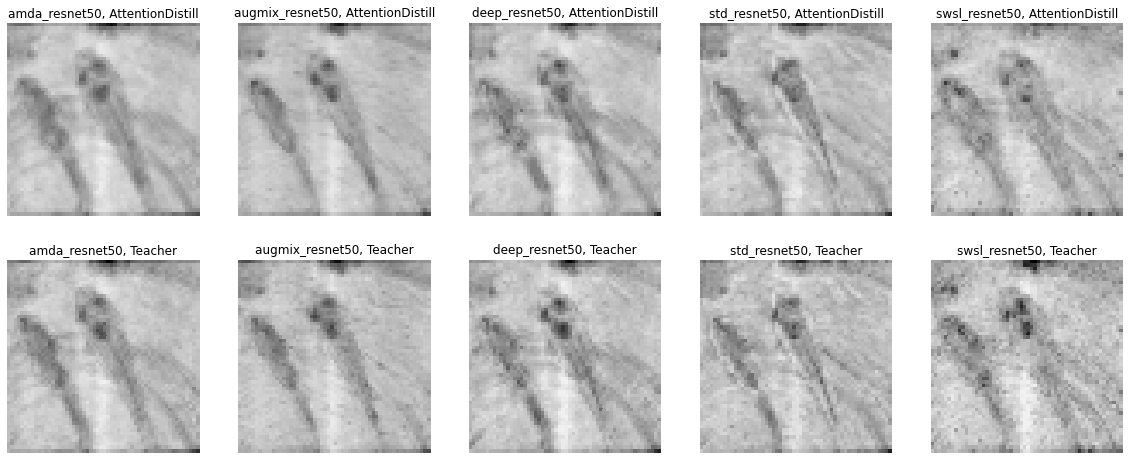

In [150]:
fig, axes = plt.subplots(len(filtered) // 5, 5, figsize=(20, 8))
cmap = sns.light_palette("black", as_cmap=True)

for ax, ((index, loss, teacher), df_part) in zip(axes.flatten(), filtered.groupby(by=["Sample Idx", "Loss", "Teacher"])):
    ax.axis("off")
    # if name == "Picture":
    #     ax.imshow(np.transpose(results[name][idx], [1, 2, 0]))
    #     continue

    sns.heatmap(df_part["Attention Map"].item(), ax=ax, square=True, cmap=cmap, vmin=0.09, vmax=0.26, cbar=False)
    ax.set_title(teacher + ", " + loss)
